#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [2]:
import pandas as pd
outstem = 'K562_rep6'
outstem2 = 'K562_rep6.region_type'
rbp = 'RBFOX2'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [3]:
variants = pd.read_csv(f'../data/variants/{outstem}.{rbp}.chr22.csv')

In [4]:
max_length=seq['seq'].str.len().max()

In [5]:
variants = variants.loc[variants['variant_seq'].str.len()<=max_length]

In [6]:
# also score normal things
seq = seq.loc[seq['name'].isin(variants['name'])]

In [7]:
from prismnet.utils import datautils

In [8]:
one_hot_wt = datautils.convert_one_hot(seq['seq'], max_length)
one_hot_var = datautils.convert_one_hot(variants['variant_seq'], max_length)

In [9]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput.set_index('name').loc[seq['name'],target_col]
targets_wt = target_df.values


In [10]:
one_hot_var = datautils.convert_one_hot(variants['variant_seq'], max_length)
targets_var = variants.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

In [11]:
one_hot_wt.shape, one_hot_var.shape, targets_wt.shape

((435, 4, 100), (8686, 4, 100), (435, 10))

In [12]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x


In [13]:
model = PrismNet_Multitask(mode = 'seq', output_dim = targets_wt.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.maskw.model.pt'))

<All keys matched successfully>

In [14]:
class SeqicSHAPE_Multitask(torch.utils.data.Dataset):
    def __init__(self, X, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [15]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
    
    
#     SeqicSHAPE_Multitask(train[0], train[1], is_infer=False, use_structure=False), 
# batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_wt, targets_wt, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

test_loader_var  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_var, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


print("Test  set:", len(test_loader.dataset))
print("Test  set:", len(test_loader_var.dataset))

Test  set: 435
Test  set: 8686


In [16]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            
    y_pred=np.concatenate(y_all)
    return epoch_loss, y_pred

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [18]:
loss_test, y_pred = validate(model, device, test_loader, criterion)
loss_test_var, y_pred_var = validate(model, device, test_loader_var, criterion)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [19]:
#!/usr/bin/env python
# 
# Kui Xu, xukui.cs@gmail.com
# 2019-02-25
# ref smoothGrad

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad,Variable
import numpy as np

class SmoothGrad(object):
    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.015, t_stddev=0.015, nsamples=20, magnitude=2):
        self.model     = model
        self.device    = device
        self.train     = train
        self.only_seq  = only_seq
        self.x_stddev  = x_stddev
        self.t_stddev  = t_stddev
        self.nsamples  = nsamples
        self.magnitude = magnitude
        self.features  = model
        # import pdb; pdb.set_trace()

    def get_gradients(self, z, pred_label=None, rbp_idx = 0):
        self.model.eval()
        self.model.zero_grad()
        z = z.to(self.device)
        z.requires_grad=True
        output = self.model(z)
        
        output[:,rbp_idx].backward() # now it is a multioutput.... maybe sum is not the right way tho!
        return z.grad

    def get_smooth_gradients(self, z, y=None, rbp_idx=0):
        return self.__call__(z, y, rbp_idx = rbp_idx)
        
    def __call__(self, z, y=None,rbp_idx = 0):
        """[summary]
        
        Args:
            z ([type]): [description] X
            y ([type]): [description] Y
            x_stddev (float, optional): [description]. Defaults to 0.15.
            t_stddev (float, optional): [description]. Defaults to 0.15.
            nsamples (int, optional):   [description]. Defaults to 20.
            magnitude (int, optional):  magnitude:0,1,2; 0: original gradient, 1: absolute value of the gradient,
                                        2: square value of the gradient. Defaults to 2.
        
        Returns:
            [type]: [description]
        """

        # 1. for sequece
        x = z[:,:,:,:4] # .data.cpu()
        x_stddev   = (self.x_stddev * (x.max()-x.min())).to(self.device).item() 

        total_grad = torch.zeros(z.shape).to(self.device)
        x_noise    = torch.zeros(x.shape).to(self.device)
        if not self.only_seq:
            # 2. for structure  
            t = z[:,:,:,4:] #.data.cpu()
            t_stddev = (self.t_stddev * (t.max()-t.min())).to(self.device).item() 
            #t_total_grad = torch.zeros(t.shape)
            t_noise = torch.zeros(t.shape).to(self.device)

        for i in range(self.nsamples):
            x_plus_noise = x + x_noise.zero_().normal_(0, x_stddev)
            if self.only_seq:
                z_plus_noise = x_plus_noise
            else:
                t_plus_noise = t + t_noise.zero_().normal_(0, t_stddev)
                z_plus_noise = torch.cat((x_plus_noise, t_plus_noise), dim=3)
            #print("z_plus_noise:",z_plus_noise.size())
            grad = self.get_gradients(z_plus_noise, y, rbp_idx = rbp_idx)
            if self.magnitude == 1:
                total_grad += torch.abs(grad)
            elif self.magnitude == 2:
                total_grad += grad * grad
            
            # total_grad += grad * grad
        total_grad /= self.nsamples
        return total_grad

    def get_batch_gradients(self, X, Y=None, rbp_idx = 0):
        if Y is not None:
            assert len(X) == len(Y), "The size of input {} and target {} are not matched.".format(len(X), len(Y))
        g = torch.zeros_like(X)
        for i in range(X.shape[0]):
            x        = X[i:i+1]
            if Y is not None:
                y    = Y[i:i+1]
            else:
                y    = None
            g[i:i+1] =  self.get_smooth_gradients(x, y, rbp_idx = rbp_idx)
            # g[i:i+1] =  self.get_gradients(x, y)
        return g


def generate_saliency(model, x, y=None, smooth=False, nsamples=2, stddev=0.15, only_seq=False, \
    train=False):
    saliency = SmoothGrad(model, only_seq, train)
    x_grad   = saliency.get_smooth_gradients(x, y, nsamples=nsamples, x_stddev=stddev, t_stddev=stddev)
    return x_grad



class GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(GuidedBackpropReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input):
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors

        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'

class GuidedBackpropSmoothGrad(SmoothGrad):

    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.15, t_stddev=0.15, nsamples=20, magnitude=2):
        super(GuidedBackpropSmoothGrad, self).__init__(
            model, device, only_seq, train, x_stddev, t_stddev, nsamples, magnitude)
        for idx, module in self.features._modules.items():
            if module.__class__.__name__ is 'ReLU':
                self.features._modules[idx] = GuidedBackpropReLU()



<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2852/2063606002.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if module.__class__.__name__ is 'ReLU':


In [20]:
y_pred_var_df = pd.DataFrame(y_pred_var, index = variants.index, columns = target_df.columns)
y_pred_wt_df = pd.DataFrame(y_pred, index = seq['name'], columns = target_df.columns)
variants[f'variant_score_{rbp}'] = y_pred_var_df[f'logLR:{outstem}.{rbp}']
variants[f'wt_score_{rbp}'] = variants['name'].map(y_pred_wt_df[f'logLR:{outstem}.{rbp}'])
variants['delta_score'] = (variants[f'variant_score_{rbp}']-variants[f'wt_score_{rbp}'])
variants['MAF']=(variants['INFO/AC']/variants['INFO/AN'])

In [21]:
neg_selected_var = variants.loc[(variants['MAF']<0.001)&(variants['delta_score']<-0.2)]

In [22]:
gof_var = variants.loc[(variants['MAF']<0.001)&(variants['delta_score']>0.2)]

In [23]:
gof_var.shape

(13, 19)

In [24]:
neg_selected_var.shape

(74, 19)

In [25]:
# make a much smaller subset
one_hot_negvar = datautils.convert_one_hot(neg_selected_var['variant_seq'], max_length)
targets_var = neg_selected_var.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

test_loader_negvar  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_negvar, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


In [26]:
# make a much smaller subset
one_hot_gofvar = datautils.convert_one_hot(gof_var['variant_seq'], max_length)
targets_gofvar = gof_var.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

test_loader_gofvar  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_gofvar, targets_gofvar, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


In [27]:
def get_saliency(model, test_loader, rbp):
    model.eval()
    sgrad = GuidedBackpropSmoothGrad(model, device=device, only_seq = True)
    rbp_idx=np.where(target_col.str.contains(rbp))[0][0]
    gs = []
    for batch_idx, (x0, y0) in enumerate(test_loader):
        X, Y = x0.float().to(device), y0.to(device).float()
        output = model(X)

        guided_saliency = sgrad.get_batch_gradients(X, Y, rbp_idx = rbp_idx)
        gs.append(guided_saliency)
    gs = torch.cat(gs, axis = 0)
    return gs

In [28]:
saliency_wt = get_saliency(model, test_loader, rbp)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [29]:
saliency_var = get_saliency(model, test_loader_negvar, rbp)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [30]:
saliency_gofvar = get_saliency(model, test_loader_gofvar, rbp)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [31]:
saliency_wt.shape, saliency_var.shape

(torch.Size([435, 1, 100, 4]), torch.Size([74, 1, 100, 4]))

In [32]:
!pip install pybigwig

  Using cached pyBigWig-0.3.22-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (217 kB)
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [33]:
import pyBigWig
import numpy as np

class strand_specific_wig:
    def __init__(self, plus, minus):
        self.plus = pyBigWig.open(plus)
        self.minus = pyBigWig.open(minus)
        
    def fetch(self, chrom = None, start= None, end=None, strand= None, interval = None):
        ''' return icSHAPE reacitivity for a bedtool interval or chrom, start, end, strand'''
        if interval:
            start = interval.start
            end = interval.end
            strand = interval.strand
            chrom = interval.chrom
        if strand == '-':
            icshape_data = self.minus
        else:
            icshape_data = self.plus
        values = icshape_data.values(chrom, start, end)
        if strand == '-':
            values = values[::-1]
        return np.nan_to_num(np.array(values), 0)

In [34]:
rbp_wig_cits = strand_specific_wig(f'../data/CITS/{rbp}.pos.bw',
                                 f'../data/CITS/{rbp}.neg.bw'
                                 )
rbp_wig_cov = strand_specific_wig(f'../data/COV/{rbp}.pos.bw',
                             f'../data/COV/{rbp}.neg.bw'
                             )

In [35]:
!pip install logomaker

  Using cached logomaker-0.8-py2.py3-none-any.whl (11.8 MB)
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [44]:
import seaborn as sns
import logomaker
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def plot_saliency(gs, index, subset_seq_df, one_hot):
    index2seq = 'ACGU'
    

    # find coverage
    window_name = subset_seq_df.iloc[index]['name']
    print(window_name)
    row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
    wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
    wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

    seq_values = one_hot[index,:,:] # [1,4,100]
    gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values = gradient_values * seq_values.T # 4*100
    saliency_df = pd.DataFrame(saliency_values.T)
    saliency_df.index = list(index2seq)

    saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
    saliency_df.index = np.arange(saliency_df.shape[0])

    f, ax = plt.subplots(2,1, sharex = True, figsize = (12,4))
    logomaker.Logo(saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(wig_values)), wig_values, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
#     ax[2].bar(np.arange(len(wig_values_cits)), wig_values_cits, color = 'lightgrey')
#     ax[2].plot(gaussian_filter1d(wig_values_cits, 3), color = 'tomato', label = 'smoothed CITS')
#     ax[2].set_ylabel('#CITS')

    ax[0].set_title(row['chrom'] + ':'+str(row['start'])+'-'+str(row['end'])+':'+row['strand'])
    sns.despine()
    
    if 'POS' in subset_seq_df.iloc[index]:
        print(subset_seq_df.iloc[index]['POS']-row['start'])
        if row['strand']=='+':
            index = subset_seq_df.iloc[index]['POS']-row['start']
            
        else:
            index = row['end']-subset_seq_df.iloc[index]['POS']
        ax[0].text(index-0.5, max(saliency_values[index,:]), '*')

In [37]:
neg_selected_var['rbp_idx'] = np.arange(neg_selected_var.shape[0])
seq['rbp_idx'] = np.arange(seq.shape[0])


/tmp/ipykernel_2852/994793822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_selected_var['rbp_idx'] = np.arange(neg_selected_var.shape[0])


In [38]:
variants['gene_name'].value_counts()

C22orf34            1277
DGCR8                882
PI4KAP2              426
PRAME                316
PPP6R2               311
                    ... 
RAC2                  14
PICK1                 14
PACSIN2               12
TPTEP2:RP1-5O6.4       9
XBP1                   7
Name: gene_name, Length: 74, dtype: int64

In [71]:
neg_selected_var['gene_name'].value_counts()

C22orf34           20
GRAMD4             12
DGCR8               9
PRAME               5
CECR7               4
PPP6R2              4
MICAL3              4
COMT                2
BCR                 2
EIF3L               2
PLA2G6              2
TPTEP1:KB-7G2.9     2
MED15               1
HIC2                1
CABIN1              1
DGCR2               1
HIRA                1
PI4KAP2             1
Name: gene_name, dtype: int64

In [73]:
neg_selected_var.loc[neg_selected_var['gene_name']=='PPP6R2']

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/AC,INFO/AN,variant_score_RBFOX2,wt_score_RBFOX2,delta_score,MAF,rbp_idx
4314,9608,chr22,50433669,rs1603399551,T,G,5633240,CGGGGGCATGGATGCTGGGCAGGGGCCGGGCATTTGCTCTGGAGGT...,INTRON,INTRON,PPP6R2,protein_coding,protein_coding,0,10930,0.177957,0.422550,-0.244594,0.000000,36
4364,9662,chr22,50434224,.,G,A,5633246,AGGGGCTGGGCATTTGCTCTGGAGGTGAACCTGGAGGAGGGCTGGG...,INTRON,INTRON,PPP6R2,protein_coding,protein_coding,1,75806,-0.010155,0.203920,-0.214075,0.000013,37
4399,9713,chr22,50434598,rs1398119780,T,G,5633250,CTGGAGGTGAACCTGGAGGAGGGCCGGGGGCAGGGATGCTGGGCAG...,SS3_PROX,SS3_PROX:INTRON,PPP6R2,protein_coding,protein_coding,9,57602,0.291540,0.529954,-0.238415,0.000156,38
4422,9741,chr22,50434645,rs1356307272,G,A,5633250,CTGGAGGTGAACCTGGAGGAGGGCCGGGGGCATGGATGCTGGGCAG...,SS3_PROX,SS3_PROX:INTRON,PPP6R2,protein_coding,protein_coding,1,100534,0.294349,0.529954,-0.235606,0.000010,39


In [40]:
neg_selected_var.iloc[44]

Unnamed: 0                                                            659
CHROM                                                               chr22
POS                                                              19116864
ID                                                           rs1025053135
REF                                                                     C
ALT                                                                     T
name                                                              5638977
variant_seq             TCTTAGCAGTAGTGGCAGGTGATCCGGTTGTGTGCATGTCCTCTCA...
feature_type_top                                                   INTRON
feature_types                                                      INTRON
gene_name                                                           DGCR2
transcript_types                   protein_coding:nonsense_mediated_decay
transcript_type_top                                        protein_coding
INFO/AC                               

5638977
28


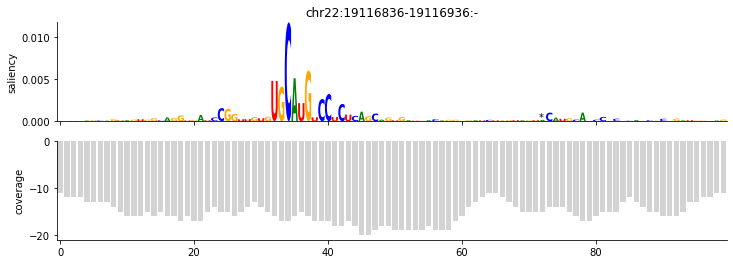

In [63]:
plot_saliency(saliency_var, 44, neg_selected_var, one_hot_negvar)
plt.savefig('DGCR8_rs1025053135.var.pdf')

In [59]:
seq.loc[seq['name']==neg_selected_var.iloc[44]['name'], 'rbp_idx'].values[0]

242

5638977


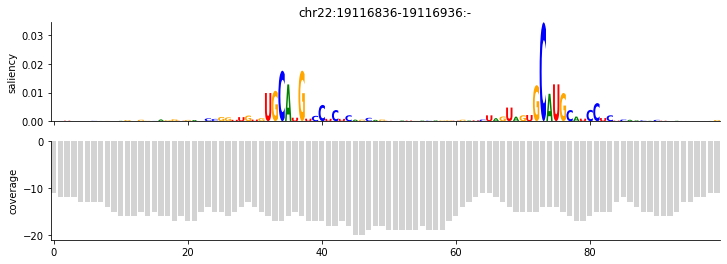

In [64]:
plot_saliency(saliency_wt, seq.loc[seq['name']==neg_selected_var.iloc[44]['name'], 'rbp_idx'].values[0], seq, one_hot_wt)
plt.savefig('DGCR8_rs1025053135.wt.pdf')

In [61]:
def plot_many_saliency(gs, indices, subset_seq_df, one_hot):
    index2seq = 'ACGU'
    

    # find coverage
    all_wig_value = []
    all_saliency_values = []
    window_names = subset_seq_df.loc[subset_seq_df['rbp_idx'].isin(indices), 'name']
    sub = megaoutput.loc[megaoutput['name'].isin(window_names)].iloc[0]
    for index in indices:
        window_name = subset_seq_df.iloc[index]['name']
        row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
        wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
        wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

        seq_values = one_hot[index,:,:] # [1,4,100]
        gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
        saliency_values = gradient_values * seq_values.T # 4*100
        saliency_df = pd.DataFrame(saliency_values.T)
        saliency_df.index = list(index2seq)

        saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
        saliency_df.index = np.arange(saliency_df.shape[0])
        
        all_wig_value.append(wig_values)
        all_saliency_values.append(saliency_df)
        
    
    all_wig_value = np.concatenate(all_wig_value)
    all_saliency_df = pd.concat(all_saliency_values, axis = 0, ignore_index = True)
    print(all_saliency_df)
    
    f, ax = plt.subplots(2,1, sharex = True, figsize = (60,4))
    logomaker.Logo(all_saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(all_wig_value)), all_wig_value, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
    

    ax[0].set_title(row['chrom'] + ':'+str(sub['start'].min())+'-'+str(sub['end'].max())+':'+row['strand'])
    print(row['chrom'] + ':'+str(sub['start'].min())+'-'+str(sub['end'].max())+':'+row['strand'])
    sns.despine()

            A         C         G         U
0    0.000000  0.000000  0.000000  0.000005
1    0.000031  0.000000  0.000000  0.000000
2    0.000000  0.000058  0.000000  0.000000
3    0.000105  0.000000  0.000000  0.000000
4    0.000000  0.000000  0.000000  0.000018
..        ...       ...       ...       ...
644  0.000000  0.000000  0.000023  0.000000
645  0.000041  0.000000  0.000000  0.000000
646  0.000000  0.000000  0.000196  0.000000
647  0.000000  0.000016  0.000000  0.000000
648  0.000000  0.000000  0.000066  0.000000

[649 rows x 4 columns]
chr22:17100881-17100981:+


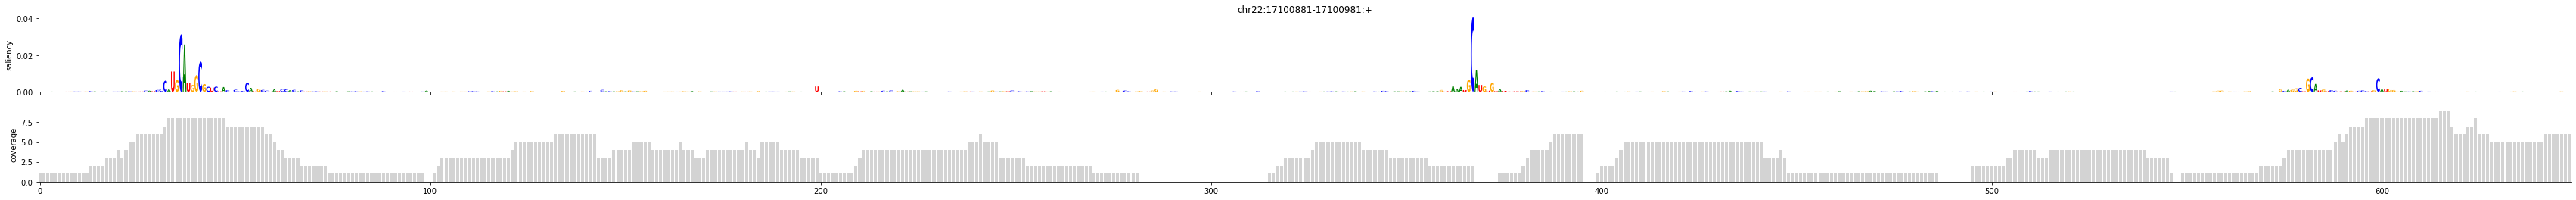

In [62]:
plot_many_saliency(saliency_wt, [8,9,10,11,12,13,14], seq, one_hot_wt)